## EE 372 Assignment 3

#### Name:  
#### Date: 

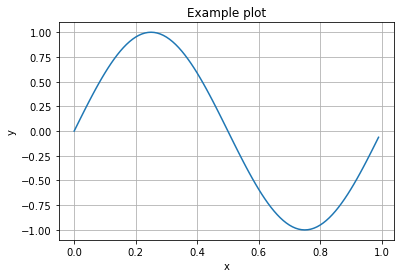

In [1]:
%matplotlib inline

# The only libraries you should need for this assignment. 
# Execute this cell first. (You should get a sine wave.)
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0,1.0, 0.01)
y = np.sin(2*np.pi*x)
plt.plot(x,y)
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Example plot')
plt.show()

### Question I: Minhashing

1.

We can describe a read as a set of unique overlapping $k$-mers, and we would expect similar reads to have similar sets. Write a function that takes $k$ and a read as inputs and outputs a dictionary indicating which of the $4^k$ $k$-mers are in the read.

In [2]:
from collections import Counter

def get_kmer_dict(read, k):
    return Counter([read[i:i+k] for i in range(0, len(read)-k+1)])

kmer_test = ''.join(np.random.choice(['A', 'C', 'T', 'G'], 10))
print(kmer_test)
print(get_kmer_dict(kmer_test, 4))

GACCGGCGTA
Counter({'CGGC': 1, 'CCGG': 1, 'ACCG': 1, 'GACC': 1, 'CGTA': 1, 'GGCG': 1, 'GCGT': 1})


2.

If we think of each read as a set of $k$-mers, a natural metric of similarity between two reads $R_1$ and $R_2$ is the Jaccard similarity, which is defined as
\\[
J(R_1,R_2) = \frac{|R_1 \cap R_2|}{|R_1|+|R_2|-|R_1 \cap R_2|}.
\\]

Explain how this metric captures similarity between two sets and how you might use this metric to align reads (2-3 sentences). Compute the minimum and maximum possible Jaccard similarity between any two sets.

The Jaccard similarity captures the amount of overlap between two sets. Therefore the more similar two sets are, the greater the Jaccard similarity would be. This metric is useful in seeing which pair of reads have the most amount of overlap based on their representation as overlapping $k$-mers, and reads with greater overlap are more likely to align well together. The maximum Jaccard similarity is 1 (identical sets), and the minimum Jaccard similarity is 0 (disjoint sets).

3.

Write a function to compute the Jaccard similarity between two dictionaries outputted by your function from part 1. Using this function and the one you wrote for part 1, compute the Jaccard similarity between the reads <tt>CATGGACCGACCAG</tt> and <tt>GCAGTACCGATCGT</tt> for $k = 3$. What is the runtime complexity of your function? If you have $N$ reads of length $L$ each, what is the worst-case runtime complexity for computing the Jaccard similarity between every pair of reads?

Since reads are represented using dictionaries of $k$-mers, the cost of looking up whether a $k$-mer is in a read is $O(1)$. The runtime complexity of comparing two reads is $O(L)$ where $L$ is the length of the read. With $N$ reads, we would have to perform $O(N^2)$ pairwise comparisons, resulting in an overall complexity of $O(N^2L)$.

In [3]:
r1 = 'CATGGACCGACCAG'
r2 = 'GCAGTACCGATCGT'
k = 3

def jaccard_similarity(r1, r2):
    intersect = sum([1. for i in r1 if i in r2])
    union = len(r1)+len(r2)-intersect
    return intersect/union

js = jaccard_similarity(get_kmer_dict(r1, k), get_kmer_dict(r2, k))
print('The Jaccard similarity is %.3f.'%(js))

The Jaccard similarity is 0.222.


4.

Suppose you have a function that hashes a $k$-mer to a value between $1$ and $4^k$. For minhashing, you would use this hash function to map each unique $k$-mer in a read to an index, ultimately returning the smallest index. Prove that the probability that two sets will generate the same minhash index is equal to their Jaccard similarity.

Intuitively, the only way the two sets would be hashed to the same value is if the element resulting in the smallest hash index is the same (i.e. in the intersection of the two sets). The probability of this element being in the intersection of the two sets is exactly the Jaccard similarity of the two sets since we can choose any element from the union of the two sets. See [lecture 9 notes](http://data-science-sequencing.github.io/Win2018/lectures/lecture9/#higherr) for more details.

5.

In practice, we would use multiple $H$ hash functions to compute multiple minhash indices for $R_1$ and $R_2$. Write down an estimator that uses the $H$ minhash indices to estimate $J(R_1,R_2)$. What is the runtime complexity of obtaining this estimation? How does this compare to the runtime you obtained for part 3?

A reasonable estimator for estimating the Jaccard similarity between sets $A$ and $B$ would be

$$ \sum_{h \in H} \frac{1(\min_{x \in A}h(x) = \min_{y \in B} h(y))}{|H|} $$

where $H$ represents the set of hash functions and $|H|$ represents the number of hash functions. For each read, we can compute each minhash value once, resulting in $O(L|H|)$ complexity per read ($O(L)$ term here from taking the minimum). This results in $O(|H|NL)$ complexity for all the reads. When performing pairwise comparisons, we can now compare the (now precomputed) minhash values for a given pair of reads, resulting in $O(N^2|H|)$ operations. Overall, the runtime becomes $O(|H|N(L+N))$. Since in practice $L \ll N$, the runtime complexity becomes $O(N^2|H|)$.

### Question II: Haplotype phasing

1.

How many measurements are in the matrix?

In [4]:
import pickle

A = pickle.load(file('matrix_sparse.pkl', 'r')).todense()
num_measurements = np.sum(np.abs(A)/2)
num_edges = np.sum(A != 0)/2
print('There are %s edges.'%(num_edges))
print('There are %s measurements.'%(num_measurements))

There are 189669 edges.
There are 219961.0 measurements.


2.

Is the graph connected?

Almost but no.

In [5]:
import networkx as nx
G = nx.Graph(A)
print('Size of components in A:')
for i, component in enumerate(nx.connected_components(G)):
    print('  Component %s contains %s nodes.'%(i, len(component)))

Size of components in A:
  Component 0 contains 4999 nodes.
  Component 1 contains 1 nodes.


3.

What is the maximum number of measurements between two SNPs?

In [6]:
print('Max # of measurements between two nodes: %s'%(np.max(np.abs(A))))

Max # of measurements between two nodes: 30.0


4.

What would you expect the maximum number of measurements to be if you had an Erdos-Renyi graph with the same number of edges?

Since each of the ${5000 \choose 2}$ possible edges are equally likely to have an edge drawn, we would would compute $189669/{5000 \choose 2}$ measurements per edge. Rounding up, we would expect the maximum number of measurements to be 1.

In [7]:
from scipy.misc import comb
print(num_edges/comb(5000, 2))

0.015176555311062212


5.

Download the ground truth of SNPs from
[here](/Win2018/assets/assignment3/ground_truth.pkl). Get the primary
eigenvector of the window of the first 200 SNPs in the adjacency matrix and find its correlation coefficient with the ground truth. Repeat with the full 5000-by-5000 adjacency matrix. How does the correlation coefficient change? Why?

The correlation coefficient decreases as we go from 200 SNPs to 5000 SNPs, highlighting how the uniform linkage model assumption gets worse as the number of SNPs increases. Since our algorithm is optimal assuming the model is correct, its performance also gets worse.

In [8]:
from scipy.stats import pearsonr

def power_method(A, eps=1e-5):
    """Fast algorithm for finding first eigenvector"""
    v = np.random.normal(0, 1, len(A))
    v /= np.linalg.norm(v)
    prev_v = np.zeros(len(v))
    i = 0
    while np.linalg.norm(prev_v-v) > eps:
        prev_v = v
        v = np.array(np.dot(A, v)).reshape(-1)
        v /= np.linalg.norm(v)
        i += 1
    print('Power method converged after %s iterations.'%(i))
    return v

ground_truth = pickle.load(file('ground_truth.pkl', 'r'))

# First 200
primary_vec = power_method(A[:200, :200])
print('For first 200 SNPs, correlation is %.2f.' \
      %(np.abs(pearsonr(ground_truth[:200], primary_vec)[0])))

# All 5000
primary_vec = power_method(A)
print('For all 5000 SNPs, correlation is %.2f.' \
      %(np.abs(pearsonr(ground_truth, primary_vec)[0])))

Power method converged after 14 iterations.
For first 200 SNPs, correlation is 0.83.
Power method converged after 65 iterations.
For all 5000 SNPs, correlation is 0.02.


### Question III: RNA-seq Quantification

1.

Implement the EM algorithm for the error-free case where all transcripts have the same length. Fill in the code in the last cell of the ipython notebook.

In [9]:
# This code was adapted from a lab designed for UC Berkeley's EE126 course

from __future__ import division
import numpy as np
t = ['ATCTCGACGCACTGC', 'GAGTTCGAACTCTTC', 'AGAGTTCCAGTGTCA',
     'AAAGCTCACTGCGGA', 'AGCGATATCAGAGTD']
K = len(t) # Number of transcripts

rho = np.random.rand(K)
rho /= sum(rho)
print rho
# This rho is unknown to us

[0.213064   0.24382804 0.29459086 0.21142675 0.03709035]


In [10]:
# sample pmf according to rho
def rand_choice( pmf ): 
    v = np.random.rand()
    tmp = 0
    for i in range(len(pmf)):
        each_val = pmf[i]
        tmp += each_val
        if v <= tmp:
            return i

# randomly generate a read from a randomly chosen transcript
def random_read( t, rho, L ): 
    chosen_seq = t[rand_choice( rho )]
    start_idx = np.random.randint(0,len(chosen_seq) - L)
    end_idx = start_idx + L
    return chosen_seq[ start_idx:end_idx ]
        
N = 1000 # Number of reads
L = 5    # Length of each read

reads = []
for i in range(N):
    reads.append( random_read(t, rho, L) )
    
print 'First 20 reads...\n', reads[0:20]   

First 20 reads...
['TTCCA', 'GTGTC', 'AGTGT', 'GTGTC', 'AGAGT', 'AAGCT', 'TTCCA', 'AGTGT', 'CAGTG', 'TTCGA', 'AAGCT', 'TCACT', 'TCGAC', 'GTGTC', 'GTTCC', 'CGAAC', 'TCCAG', 'ATCTC', 'CGATA', 'GAACT']


In [11]:
N_iter = 100 # number of E/M iterations

# Naive alignment algorithm for no-error situation
def find_all_alignments(t, read):
    tmp = []
    for j in range(len(t)):
        if read in t[j]:
            tmp.append(j)
    return tmp

# A: Compatibility List. A[i] is a list of transcripts that read i aligns to
A = []
for each_read in reads:
    A.append( find_all_alignments(t, each_read) )

Z = np.zeros([N, K]) # hidden state prior
rho_est = (1/K)*np.ones([1,K])

# ==============================================================================
# Your EM code here. Save your final answer as rho_est
    
# First initialize Z
for i in range(N):
    for j in range(len(A[i])):
        Z[i][A[i][j]] = 1
        
# EM iterations
for iter in range(N_iter):
    # E step
    for i in range(N):
        new_row = np.multiply(rho_est,[Z[i] != 0])
        Z[i] = new_row/np.sum(new_row)
    # M step    
    rho_est = np.sum(Z,axis=0)/N
    
# ==============================================================================
    
print '(real) rho', rho
print '(est.) rho', rho_est

(real) rho [0.213064   0.24382804 0.29459086 0.21142675 0.03709035]
(est.) rho [0.23148169 0.24000152 0.29498495 0.19651831 0.03701353]


2.

Instead of equal transcript length $\ell$, let us now consider the case when the transcript lengths are $\ell_1, \ell_2, \dots, \ell_K$. The reads are still error-free.
- Develop the log likelihood model
- Derive the EM iterative algorithm for this model, specializing from the general EM discussed in the lecture.

_This problem was discussed in the [lecture 12 notes](http://data-science-sequencing.github.io/Win2018/lectures/lecture12/#algo2), and the following solution is written by Mark Nishimura._

As before, we have

$$ p(x) = \sum_k p(x | k) p(k) $$

Now, assuming that each transcript appears at most once in each read, and each read has length $L$, we have

$$p(x | k) = \frac{\mathbb{I}(x \in T_k)}{\ell_k - L + 1} \approx \frac{\mathbb{I}(x \in T_k)}{\ell_k} \quad \text{(for $L \ll \ell_k$)}$$

Furthermore, since the transcripts have different lengths $\ell_k$ AND abundances $\rho_k$, the probability that a read is selected from transcript $k$ is (again, when $L \ll \ell_k$)

$$p(k) = \frac{\rho_k\ell_k}{\sum_k {\rho_k\ell_k}} $$

Therefore, the empirical log likelihood of the dataset $\mathcal{D}$ is:

$$ \sum_{x \in \mathcal{D}}  \log \sum_k \frac{\mathbb{I}(x \in T_k)}{\ell_k} \cdot \frac{\rho_k\ell_k}{\sum_k \rho_k \ell_k} $$

The **E step** is as follows:

$$
\begin{align*}
p(k | x; \rho) &\propto p(x | k) p(k) \\
	    &\propto \frac{\mathbb{I}(x \in T_k)}{\ell_k} \cdot \frac{\rho_k\ell_k}{\sum_k \rho_k \ell_k} \\
	    &\propto \frac{\rho_k\mathbb{I}(x \in T_k)}{\sum_k \rho_k \ell_k} \\
\end{align*}
$$

Computing the above for all possible values of $k$ and then dividing by that sum gives:

$$ = \frac{\rho_k \mathbb{I}(x \in T_k)}{\sum_{k} \rho_k \mathbb{I}(x \in T_k)} $$

Letting $\tau_k= \frac{\rho_k\ell_k}{\sum_k \rho_k \ell_k}$, we have

$$ = \frac{\frac{\tau_k}{\ell_k}  \mathbb{I}(x \in T_k)}{\sum_{k} \frac{\tau_k}{\ell_k} \mathbb{I}(x \in T_k)} $$

The **M step** is as follows. Let the current parameter estimate be $\rho'$. Noting that $E_{k \sim p(k | x; \rho')} [\log p(x | k)]$ does not depend on $\rho$,

$$
\begin{align*}
\arg \max_\rho \sum_x E_{k \sim p(k | x)} [\log p(x, k)] &= \arg \max_\rho \sum_x E_{k \sim p(k | x; \rho')} [\log p(x | k)] + \sum_x E_{k \sim p(x | k; \rho')} [\log p(k)] \\
										    &= \arg \max_\rho \sum_x E_{k \sim p(k | x; \rho')} [\log p(k)] \\
										    &= \arg \max_\rho \sum_k \log \frac{\rho_k\ell_k}{\sum_k \rho_k \ell_k} \sum_x \frac{\rho_k \mathbb{I}(x \in T_k)}{\sum_{k} \rho_k \mathbb{I}(x \in T_k)} \\
\end{align*}
$$

Letting $\tau_k= \frac{\rho_k\ell_k}{\sum_k \rho_k \ell_k}$ we have:

$$ = \arg \max_\rho \sum_k \log \tau_k \sum_x \frac{\frac{\tau_k}{\ell_k}  \mathbb{I}(x \in T_k)}{\sum_{k} \frac{\tau_k}{\ell_k} \mathbb{I}(x \in T_k)} $$

from which we deduce that

$$ \tau_k = \frac{1}{N} \sum_x \frac{\frac{\tau_k}{\ell_k}  \mathbb{I}(x \in T_k)}{\sum_{k} \frac{\tau_k}{\ell_k} \mathbb{I}(x \in T_k)} $$

Actually, the whole algorithm can be performed in terms of $\tau_k$, and at the end we can set:

$$ \rho_k \propto \tau_k / \ell_k $$

with the appropriate normalization at the end so that the $\rho_k$'s add up to 1.

3.

Now suppose the reads have errors: each base is read correctly with probability $1-\delta$ and incorrectly with probability $\delta$, and if incorrect the base can be read equally likely as any of the other three possibilities.
- Generalize the log likelihood model in Part 1 to this case.
- Derive the EM iterative algorithm for this model, again specializing from the general EM algorithm.
- Suppose the alignment tool at your disposal can compute all exact alignments and all approximate alignments up to one base different. If the error rate $\delta$ is small such that the chance of a read having two or more errors is negligible, explain how you would use your alignment tool in implementing the EM algorithm derived in the previous part.

_The following solution is written by Mark Nishimura._

The log-likelihood model is:

$$ \log p(x) = \log \sum_{k, e} p(x | k, e) p(k) p(e) $$

where $p(k)$ is the same as before, $e$ is a vector of independent Bernoulli RV each w/ parameter $\delta$ i.e. $p(e_i) = \delta^{e_i} (1 - \delta)^{(1 - e_i)}$, and $p(e) = \prod_{i=1}^L p(e_i)$. Let $e$ be 1 at indices $I$, and let $X_e$ be the set of all possible reads that differ from $x$ at all locations $I$. Then:

$$ p(x | k, I(e)) \propto \#\{ x' \in T_k | \text{$x'$ differs from $x$ in exactly the locations $I$}\}$$

We then normalize this probability after computing it for all possible $x$'s. The EM algorithm is now:

**E step**: 

$$p(k, e | x; \rho, \delta) = \frac{p(x | e, k) p(e; \delta) p(k ; \rho)}{\sum_{e, k}p(x | e, k) p(e; \delta) p(k ; \rho)},$$

with all of these given by their expressions above.

**M step**: To estimate the parameter values, we first find $p(k | x ; \rho') = \sum_e p(k, e | x; \rho', \delta')$ and similarly for $p(e | x ; \delta') = \sum_k p(k, e | x; \rho', \delta')$. Then we have:

$$ \rho_k = \frac{1}{N}\sum_x p(k | x ; \rho') $$
$$ \delta = \frac{1}{N} \sum_x p(e | x ; \delta') $$

If we have an aligner, then we can ignore the error probability and just set

$$ p(x | k, e) = p(x | k) = \frac{(\text{number of places $x$ aligns to $T_k$ with at most 1 error})}{\ell_k - L + 1}$$

We also no longer need to estimate $\delta$ and can do the whole algorithm as in part (1) from here.

### Question IV: Single-cell RNA-seq

In [12]:
# Load data
X = np.loadtxt('Zeisel_data/Zeisel_expr.txt').T
genes = np.loadtxt('Zeisel_data/Zeisel_genes.txt', delimiter='\n', dtype=str)
labels = np.loadtxt('Zeisel_data/Zeisel_labels.txt', delimiter='\n', dtype=str)

1.

You can find the paper describing their experiment [here](https://drive.google.com/drive/folders/1kT6g707L0pELvNNmz069ZROD5awidiu6?usp=sharing). Answer the following questions:
- What kind of cells were they looking at? (and what organism did they come from?)
- How many cells were there?
- What is a unique molecular identifier and how was it used?
- How did they validate their findings?
- What was their motivation for performing the experiment?
- What did they discover?

They were looking at brain cells from adult mice. 3005 cells were reported. The unique molecular identifer is an oligonucleotide tag attached to transcripts during sequencing, allowing the authors to correct for amplification bias and directly count individual RNA molecules. The authors validated their findings physically using immunohistochemistry, single molecule RNA FISH, and electrophysiology. They validated their findings statistically by resampling and recomputing their clusters. Their motivation for performing the experiment was to classify mouse brain cells based on single-cell RNA-Seq expression. They discovered 9 major cell types and 47 subtypes.

2.

Plot two histograms: log(total counts) across cells and log(total counts) across genes. Why do we need to take a log here? What does this say about the data? Remove the columns of the matrix corresponding to genes that are expressed less than 25 times across all cells. How many genes are removed?

We need to take a log because the data will then look more normally distributed, and the resulting histograms would be more insightful. This shows that the data is heavily biased towards smaller counts (i.e. the vast majority of transcript counts are small).

4721 genes removed.


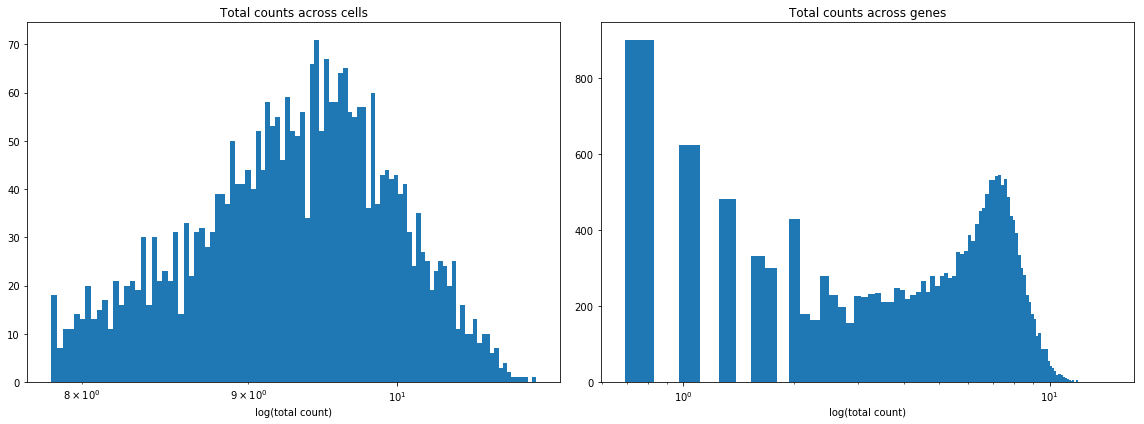

In [13]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.title('Total counts across cells')
plt.hist(np.log(np.sum(X, 1)), 100)
plt.xscale('log')
plt.xlabel('log(total count)')
plt.subplot(1, 2, 2)
plt.title('Total counts across genes')
plt.hist(np.log(np.sum(X, 0)), 100)
plt.xscale('log')
plt.xlabel('log(total count)')
plt.tight_layout()

keep_genes = np.sum(X, 0) >= 25
X = X[:, keep_genes]
genes = genes[keep_genes]

print('%s genes removed.'%(np.sum(~keep_genes)))

3.

Transform the data by adding 1 to all entries and taking the log (this is common practice). Two common dimensionality reduction strategies are principal component analysis (PCA) and t-distributed stochastic neighbor embedding (tSNE). You can implement PCA using the Python [sklearn package](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). We recommend [this](https://github.com/danielfrg/tsne) tSNE package for generating a tSNE embedding. List a pro and a con of each of the two methods. Create the following three plots and report what you see (for all plots, color points by their label):
- Run PCA and plot the first two principal components
- Run tSNE and plot the first two tSNE components (Note: this may take a few minutes)
- Run tSNE on the top 50 principal components and plot the first two tSNE components

PCA has several nice theoretical properties (see [this blog post](https://liorpachter.wordpress.com/2014/05/26/what-is-principal-component-analysis/)), including its interpretability. All principal components are orthogonal (i.e. uncorrelated) and obtained via a linear transform of the original data. The first principal component captures the maximum variance explained by the data along one axis. One issue with PCA is that it's quite sensitive to outliers.

tSNE is widely adopted because its nonlinearity generally results in more visually appealing clusters, indicating that it's more robust to certain types of noise compared to PCA. The optimization associated with tSNE is nonconvex, however, and therefore different runs of tSNE will produce different results. Also the tSNE "components" are harder to interpret.

In [14]:
from tsne import bh_sne
from sklearn.decomposition import PCA

# Log transform
X = np.log(1+X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# tSNE on full data
X_tsne = bh_sne(X, random_state=np.random.seed(0))

# tSNE on top 50 principal components
pca = PCA(n_components=50)
X_pca_ = pca.fit_transform(X)
X_tsne_pca = bh_sne(X_pca_)

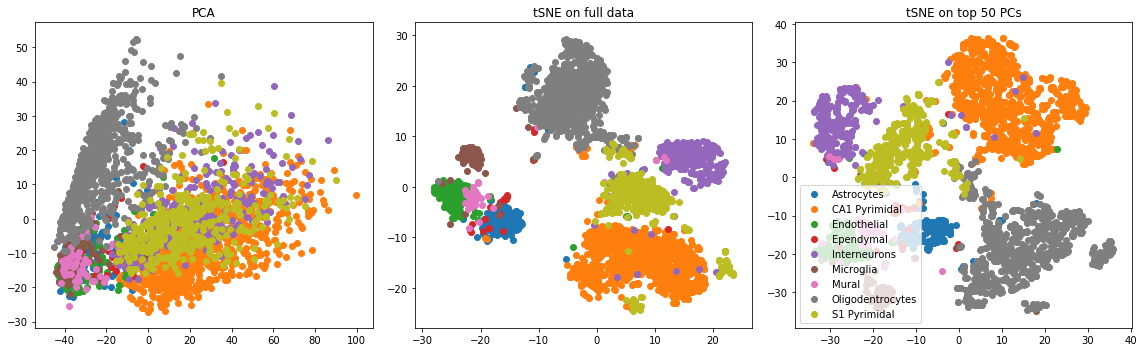

In [15]:
def plot_with_labels(X, Y):
    for i in np.unique(Y):
        plt.scatter(X[Y == i, 0], X[Y == i, 1], label=i)

plt.figure(figsize = (16, 5))
plt.subplot(1, 3, 1)
plot_with_labels(X_pca, labels)
plt.title('PCA')
plt.subplot(1, 3, 2)
plot_with_labels(X_tsne, labels)
plt.title('tSNE on full data')
plt.subplot(1, 3, 3)
plot_with_labels(X_tsne_pca, labels)
plt.title('tSNE on top 50 PCs')
plt.legend()
plt.tight_layout()
plt.show()

4.

Using sklearn, we will test 4 different [clustering algorithms]((http://scikit-learn.org/stable/modules/clustering.html) on the dataset and evaluate their performance using the true labels provided by the authors. The four clustering methods are K-means clustering, spectral clustering, affinity propagation, and density-based spatial clustering of applications with noise (DBSCAN). Using the top 50 principal components for the log-transformed data, for each clustering method:
- Describe the hyperparameters one needs to tune
- Tune the hyperparameters until you obtain reasonable labels (i.e. you obtain about 9 clusters)
- Report your final hyperparameters
- Compare your labels to the true labels using sklearn's [adjusted Rand Index](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html).

In [16]:
from sklearn.cluster import KMeans, SpectralClustering, AffinityPropagation, DBSCAN
from sklearn.metrics import adjusted_rand_score
num_clust = len(np.unique(labels))

For K-means, we only need to set the number of desired clusters: 9.

In [17]:
method = KMeans(n_clusters=num_clust)
Y = method.fit_predict(X_pca_)
print('For KMeans, the ARI was %.2f.'%(adjusted_rand_score(labels, Y)))

For KMeans, the ARI was 0.36.


For spectral clustering, we also only need to set the number of desired clusters: 9.

In [18]:
method = SpectralClustering(n_clusters=num_clust)
Y = method.fit_predict(X_pca_[:, :1])
print('For spectral clustering, the ARI was %.2f.'%(adjusted_rand_score(labels, Y)))

/Users/jessezhang/anaconda2/lib/python2.7/site-packages/sklearn/utils/graph.py:115: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, np.int)


For spectral clustering, the ARI was 0.16.


For affinity propagation, we need to tune both a preference parameter for determining which points are exemplars and a damping parameter for avoiding numerical oscillations.

In [19]:
d = 0.5
p = -40000
method = AffinityPropagation(damping=d, preference=p)
Y = method.fit_predict(X_pca_)
print('For affinity propagation with damping = %.3f, preference = %.3f, the ARI was %.2f.' \
      %(d, p, adjusted_rand_score(labels, Y)))

For affinity propagation with damping = 0.500, preference = -40000.000, the ARI was 0.37.


For DBSCAN, we need to tune our choice of the max distance between two samples in the same neighborhood.

In [20]:
eps = 8.67
method = DBSCAN(eps=eps)
Y = method.fit_predict(X_pca_)
print('For DBSCAN with eps = %.2f, the ARI was %.2f.' \
      %(eps, adjusted_rand_score(labels, Y)))

For DBSCAN with eps = 8.67, the ARI was 0.05.


5.

Using scipy's [_t_-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) function and the log-transformed data, identify the top 5 most significant genes for each of the authors' reported clusters.

In [21]:
from scipy.stats import ttest_ind

for i in np.unique(labels):
    t, p = ttest_ind(X[labels == i], X[labels != i])
    significant_genes = genes[np.argsort(p)[:5]]
    print('For %s, the top 5 genes were:\n  %s\n'%(i, ', '.join(significant_genes)))

For Astrocytes, the top 5 genes were:
  Ntsr2, Aldoc, Lcat, Cldn10, Gja1

For CA1 Pyrimidal, the top 5 genes were:
  Nell2, Prkcb, Fam131a, Enc1, St6galnac5

For Endothelial, the top 5 genes were:
  Itm2a, Flt1, Cldn5, Ly6c1, Slco1a4

For Ependymal, the top 5 genes were:
  1700001C02Rik, Dynlrb2, Tmem212, Fam216b, Dnali1

For Interneurons, the top 5 genes were:
  Reln, Kcnip1, Htr3a, Kcnc1, Btbd11

For Microglia, the top 5 genes were:
  C1qb, Tyrobp, Lyz2, Ctss, Hpgds

For Mural, the top 5 genes were:
  Acta2, Tagln, Tpm2, Mustn1, Myl9

For Oligodentrocytes, the top 5 genes were:
  Adamts4, Dbndd2, Cmtm5, Pdlim2, Gsn

For S1 Pyrimidal, the top 5 genes were:
  Mef2c, Gm11549, Car10, Tbr1, Pcp4

